# New York Taxi Demand Forecast 

 <b>Objectives:</b> The objective is to forecast the demand for taxis by predicting the number of passengers in the next hour.
 

You must predict the total count of passengers in the next hour, using only information 
available prior to the respective period.

You can choose how you split your data into a training and test sets but the test set should be at least 
15% of the whole dataset (make sure that you don't have any data leakage).

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import  mutual_info_regression, SelectFromModel, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

sns.set(rc={'figure.figsize':(11, 4)})

# Data 
The data was originally published by the NYC Taxi and Limousine Commission (TLC) and made publicly available 
via [NYC Open Data](https://opendata.cityofnewyork.us/). For the purpose of this challenge the data was sampled 
and additional weather data was added. The weather data was published on kaggle datasets: 
[Historical Hourly Weather Data 2012-2017](https://www.kaggle.com/selfishgene/historical-hourly-weather-data).

You are provided with hourly NYC Yellow Cab trip record data from January 2016 to December 2017. The data was
originally sampled on a per-trip basis and aggregated to hourly intervals for this challenge. 
The dataset is not cleaned and can contain invalid data points or outliers.


In [3]:
df = pd.read_csv("data/nyc_taxi_data.csv", index_col=0)
df.index=pd.to_datetime(df.index, unit='s')
#df.index = df.index.tz_convert('America/New_York')
df.head()

,passenger_count,trip_distance,total_amount,humidity,pressure,temperature,weather_description,wind_direction,wind_speed
timestamp,,,,,,,,,
2017-06-21 13:00:00,26805,45733.59,285315.95,57.0,1014.0,295.37,sky is clear,290.0,3.0
2017-02-05 16:00:00,27487,50781.62,262346.81,51.0,1016.0,273.91,overcast clouds,250.0,5.0
2016-06-02 20:00:00,41686,71816.81,400042.82,82.0,1020.0,296.72,haze,90.0,5.0
2016-02-24 10:00:00,31526,44498.25,291332.16,86.0,1019.0,275.77,mist,70.0,6.0
2016-03-16 03:00:00,4138,9353.05,42545.26,81.0,1010.0,282.52,overcast clouds,15.0,1.0


In [4]:
df.dtypes

passenger_count          int64
trip_distance          float64
total_amount           float64
humidity               float64
pressure               float64
temperature            float64
weather_description     object
wind_direction         float64
wind_speed             float64
dtype: object

# 1. Data Cleaning

First, for identify outliers, let consider maximum and minimum values for each columns in dataframe. 

In [5]:
print("timestamp: [ min is {} and max is {} ]".format(df.index.min(),df.index.max()))
for col in df.columns.to_list():
    if df[col].dtype != np.object:
        print("{}: [ min is {} and max is {} ]".format(col,df[col].min(),df[col].max()))

timestamp: [ min is 2001-01-01 00:00:00 and max is 2053-03-21 16:00:00 ]
passenger_count: [ min is 1 and max is 59077 ]
trip_distance: [ min is -3337066.3800000013 and max is 19135555.27000003 ]
total_amount: [ min is 2.3 and max is 1550589.3100003153 ]
humidity: [ min is 10.0 and max is 100.0 ]
pressure: [ min is 988.0 and max is 1044.0 ]
temperature: [ min is 255.07 and max is 308.37 ]
wind_direction: [ min is 0.0 and max is 360.0 ]
wind_speed: [ min is 0.0 and max is 18.0 ]


<b>Observations</b>: 
* Trip distance contains negative values and max value is almost 2m
* Total amount - 1.5m ?
* Timestamp interval contains date out of the interval Jan 2016 and Dec 2017

Let plot a box plot to analyse distribution of data

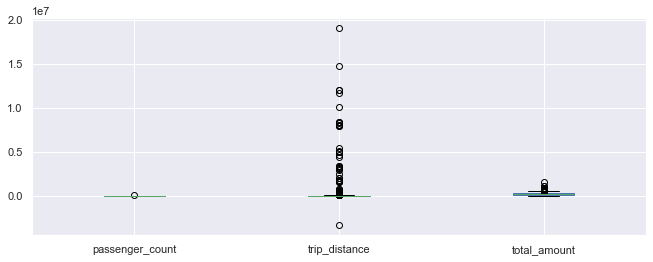

In [6]:
df[['passenger_count','trip_distance', 'total_amount']].boxplot()

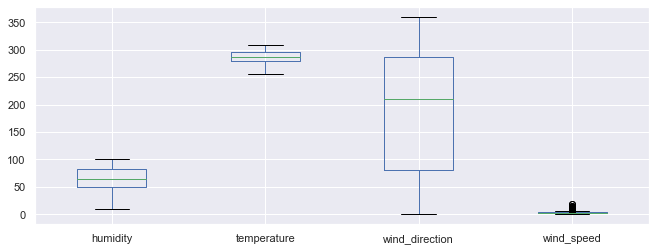

In [7]:
df[['humidity','temperature', 'wind_direction', 'wind_speed']].boxplot()

### Remove outliers - timestamp
Remove rows where timestamps are not in the interval: Jan 2016 and Dec 2017

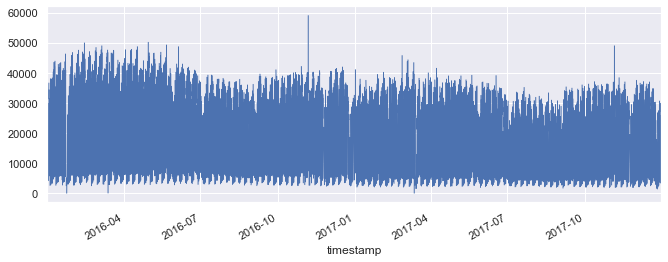

In [8]:
df_cleaned = df[(df.index > '2016-01-01') & (df.index<'2017-12-31')]
df_cleaned['passenger_count'].plot(linewidth=0.5);

In [9]:
print ("Total outliers removed",df.shape[0] - df_cleaned.shape[0])
print ("Origin shape",df.shape)

Total outliers removed 83
Origin shape (17617, 9)


### Remove outliers - trip_distance
After analising minimum and maximum values, we can notice that there're trips with negative values which must be removed

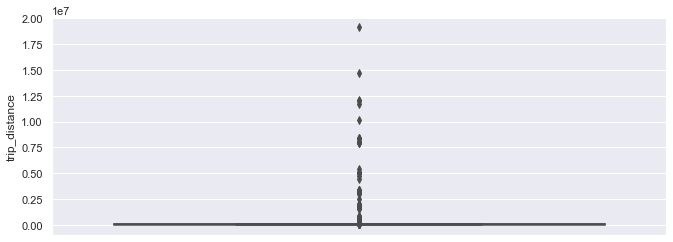

In [10]:
df_cleaned = df_cleaned[(df_cleaned.trip_distance >= 0)]
sns.boxplot(y="trip_distance", data = df_cleaned)

<b>In order to identify outliers, let check percentiles</b>

In [11]:
var = df_cleaned["trip_distance"].values
var = np.sort(var)
for i in range(0,100,10):
    print("{} percentile value is {}".format(i,var[int(len(var)*(i/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 10.15
10 percentile value is 14512.019999999986
20 percentile value is 24141.59000000001
30 percentile value is 35347.44000000002
40 percentile value is 41105.810000000296
50 percentile value is 44661.060000000296
60 percentile value is 47678.169999999904
70 percentile value is 50846.75999999977
80 percentile value is 54707.42999999969
90 percentile value is 60700.45000000001
100 percentile value is  19135555.27000003


Zooming in from 90th percentile to 100th, since the gap is too big

In [12]:
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 60700.45000000001
91 percentile value is 61600.04000000014
92 percentile value is 62617.87999999947
93 percentile value is 63675.440000000046
94 percentile value is 64847.75999999992
95 percentile value is 66278.35000000003
96 percentile value is 68019.4800000002
97 percentile value is 70336.55000000057
98 percentile value is 73466.10999999991
99 percentile value is 79166.55999999974
100 percentile value is  19135555.27000003


Zooming in further from 99th percentile to 100th

In [13]:
for i in np.arange(0.0, 1.0, 0.1):
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 79166.55999999974
99.1 percentile value is 80262.33999999924
99.2 percentile value is 82035.46999999999
99.3 percentile value is 83246.61999999976
99.4 percentile value is 87742.23000000004
99.5 percentile value is 290352.6999999991
99.6 percentile value is 353387.0499999977
99.7 percentile value is 376133.54000000044
99.8 percentile value is 1695073.0000000002
99.9 percentile value is 5051329.969999983
100 percentile value is  19135555.27000003


In [14]:
#plt.plot(var[-50:])
#plt.show()

#### Removing further outliers based on the 99.7th percentile value

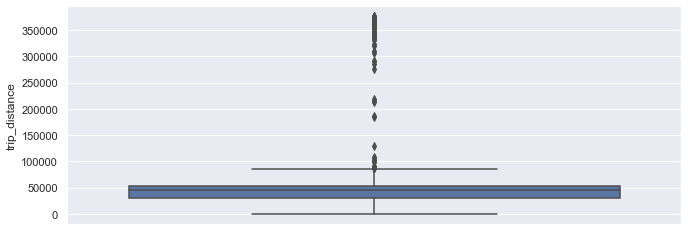

In [15]:
df_cleaned = df_cleaned[df_cleaned.trip_distance < 400000]
sns.boxplot(y="trip_distance", data = df_cleaned)

In [16]:
print ("Total outliers removed",df.shape[0] - df_cleaned.shape[0])
print ("Origin shape",df.shape)

Total outliers removed 135
Origin shape (17617, 9)


### Remove outliers - total_amount
For that, we will again check percentiles

In [17]:
var = df_cleaned["total_amount"].values
var = np.sort(var)
for i in range(0,100,10):
    print("{} percentile value is {}".format(i,var[int(len(var)*(i/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 120.85
10 percentile value is 64985.75000000277
20 percentile value is 111536.5800000072
30 percentile value is 174973.31999998973
40 percentile value is 225362.4599999721
50 percentile value is 254365.46999995853
60 percentile value is 274610.5699999445
70 percentile value is 292610.50999994803
80 percentile value is 313867.6599999437
90 percentile value is 346153.40999992273
100 percentile value is  1550589.3100003153


In [18]:
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 346153.40999992273
91 percentile value is 350214.6599999253
92 percentile value is 355039.9199999296
93 percentile value is 360250.01999992656
94 percentile value is 366127.9199999324
95 percentile value is 372929.80999991344
96 percentile value is 381208.16999990813
97 percentile value is 389903.2699999229
98 percentile value is 401989.0799999193
99 percentile value is 421744.0099999034
100 percentile value is  1550589.3100003153


In [19]:
for i in np.arange(0.0, 1.0, 0.1):
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 421744.0099999034
99.1 percentile value is 424226.08999992674
99.2 percentile value is 427695.48999989865
99.3 percentile value is 431458.9299998954
99.4 percentile value is 434838.17999990156
99.5 percentile value is 437193.1799999111
99.6 percentile value is 441087.4799999014
99.7 percentile value is 450306.8099998802
99.8 percentile value is 506214.9099999126
99.9 percentile value is 629599.3400000867
100 percentile value is  1550589.3100003153


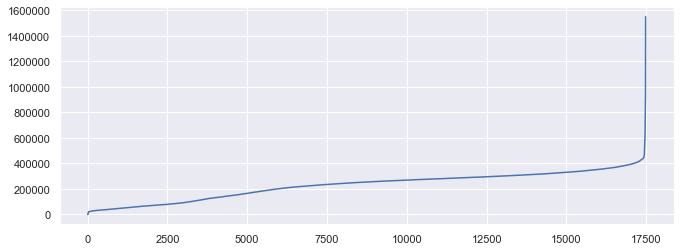

In [20]:
plt.plot(var)
plt.show()

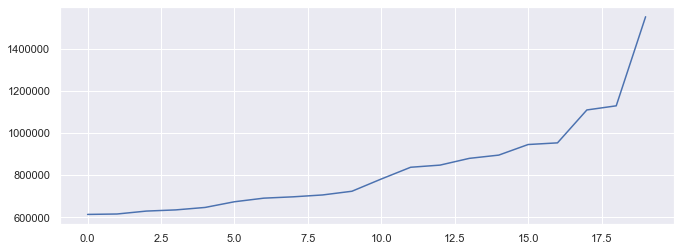

In [21]:
plt.plot(var[-20:])
plt.show()

#### Removing further outliers  
* Now looking at the last 50 values n we again find a drastic increase at around 800 000  value.
* So we remove all the data points whose far value is greater that 800 000  dollars (and less than 0).

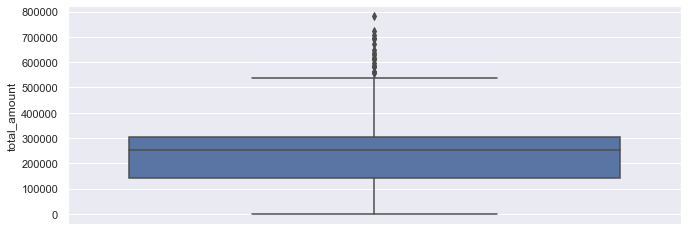

In [22]:
df_cleaned = df_cleaned[df_cleaned.total_amount < 800000]
sns.boxplot(y="total_amount", data = df_cleaned)

In [23]:
print ("Total outliers removed",df.shape[0] - df_cleaned.shape[0])
print ("Data shape",df_cleaned.shape)


Total outliers removed 144
Data shape (17473, 9)


# 2. Data Preparation

### Creating time features

In the previous step we removed outliers. Now let new features, that will help us to improve the model.
For that, we add month, day of week, hour of day and holiday features

In [24]:
df_cleaned['month'] = df_cleaned.index.month
df_cleaned['dayOfWeek'] = df_cleaned.index.dayofweek
df_cleaned['hourOfDay'] = df_cleaned.index.hour
cal = calendar()
holidays = cal.holidays(start=df_cleaned.index.min(), end=df_cleaned.index.max())
df_cleaned['holiday'] = df_cleaned.index.isin(holidays)
df_cleaned['holiday'] = df_cleaned.holiday.astype(int)
df_cleaned.head()

,passenger_count,trip_distance,total_amount,humidity,pressure,temperature,weather_description,wind_direction,wind_speed,month,dayOfWeek,hourOfDay,holiday
timestamp,,,,,,,,,,,,,
2017-06-21 13:00:00,26805,45733.59,285315.95,57.0,1014.0,295.37,sky is clear,290.0,3.0,6,2,13,0
2017-02-05 16:00:00,27487,50781.62,262346.81,51.0,1016.0,273.91,overcast clouds,250.0,5.0,2,6,16,0
2016-06-02 20:00:00,41686,71816.81,400042.82,82.0,1020.0,296.72,haze,90.0,5.0,6,3,20,0
2016-02-24 10:00:00,31526,44498.25,291332.16,86.0,1019.0,275.77,mist,70.0,6.0,2,2,10,0
2016-03-16 03:00:00,4138,9353.05,42545.26,81.0,1010.0,282.52,overcast clouds,15.0,1.0,3,2,3,0


### Creating weather features
 First, we perform exploratory analysis

In [25]:
df_cleaned.weather_description.value_counts()

sky is clear                           4276
mist                                   2518
broken clouds                          1961
scattered clouds                       1504
light rain                             1404
overcast clouds                        1386
few clouds                             1043
fog                                     512
haze                                    323
moderate rain                           251
light intensity drizzle                 201
light snow                              199
drizzle                                 134
proximity thunderstorm                   58
heavy intensity rain                     55
thunderstorm                             29
heavy snow                               17
thunderstorm with light rain             14
snow                                     11
heavy intensity drizzle                   9
thunderstorm with rain                    9
freezing rain                             5
smoke                           

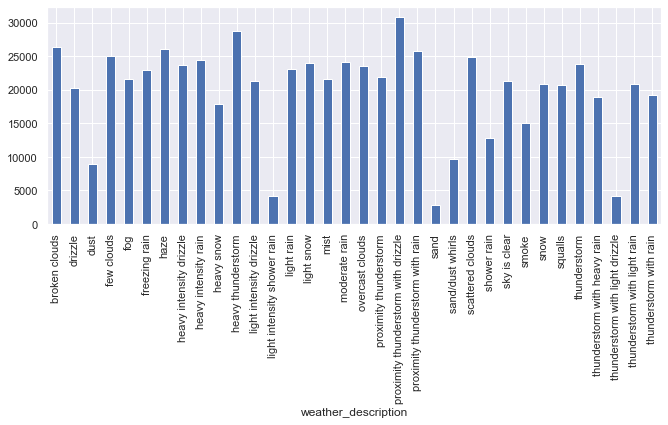

In [26]:
temp = df_cleaned.groupby("weather_description")["passenger_count"].mean()
temp.plot(kind="bar")
plt.show()

<b>Create dummies data for weather</b>

In [27]:
data_weather = df_cleaned['weather_description'].str.split(",").str.join("*").str.get_dummies(sep='*')

In [28]:
data_final = pd.concat([df_cleaned, data_weather], axis=1)
#data_final = df_cleaned
# sort by time
data_final = data_final.sort_index()

### Last 2 hour Distance and Total Amount (1 Hour Ago and 2 Hours Ago)

In [29]:
data_final['prev_passenger_count'] = data_final['passenger_count'].shift(1)
data_final['prev_2hpassenger_count'] = data_final['passenger_count'].shift(2)
data_final['prev_3hpassenger_count'] = data_final['passenger_count'].shift(3)

data_final['prev_trip_distance'] = data_final['trip_distance'].shift(1)
data_final['prev_2h_trip_distance'] = data_final['trip_distance'].shift(2)
data_final['prev_total_amount'] = data_final['total_amount'].shift(1)
data_final['prev_2h_total_amount'] = data_final['total_amount'].shift(2)
for col in ["prev_trip_distance","prev_2h_trip_distance","prev_total_amount","prev_2h_total_amount", "prev_passenger_count","prev_2hpassenger_count","prev_3hpassenger_count"]:
    data_final[col].fillna((data_final[col].mean()), inplace=True)

<b>Now we can remove columns that we don't need more</b>

In [30]:
data_final.drop(["weather_description","trip_distance","total_amount"], axis=1, inplace=True)
data_final.columns

Index(['passenger_count', 'humidity', 'pressure', 'temperature',
       'wind_direction', 'wind_speed', 'month', 'dayOfWeek', 'hourOfDay',
       'holiday', 'broken clouds', 'drizzle', 'dust', 'few clouds', 'fog',
       'freezing rain', 'haze', 'heavy intensity drizzle',
       'heavy intensity rain', 'heavy snow', 'heavy thunderstorm',
       'light intensity drizzle', 'light intensity shower rain', 'light rain',
       'light snow', 'mist', 'moderate rain', 'overcast clouds',
       'proximity thunderstorm', 'proximity thunderstorm with drizzle',
       'proximity thunderstorm with rain', 'sand', 'sand/dust whirls',
       'scattered clouds', 'shower rain', 'sky is clear', 'smoke', 'snow',
       'squalls', 'thunderstorm', 'thunderstorm with heavy rain',
       'thunderstorm with light drizzle', 'thunderstorm with light rain',
       'thunderstorm with rain', 'prev_passenger_count',
       'prev_2hpassenger_count', 'prev_3hpassenger_count',
       'prev_trip_distance', 'prev_2h_trip

<b>Check the columns with NaN values</b>

In [31]:
null_columns = data_final.columns[data_final.isnull().any()]
data_final[null_columns].isnull().sum()

humidity          1536
pressure          1536
temperature       1536
wind_direction    1536
wind_speed        1536
dtype: int64

<b>Fill NaN values in the columns "humidity","pressure","temperature","wind_direction","wind_speed" with mean </b>

In [32]:
for col in ["humidity","pressure","temperature","wind_direction","wind_speed"]:
    data_final[col].fillna((data_final[col].mean()), inplace=True)

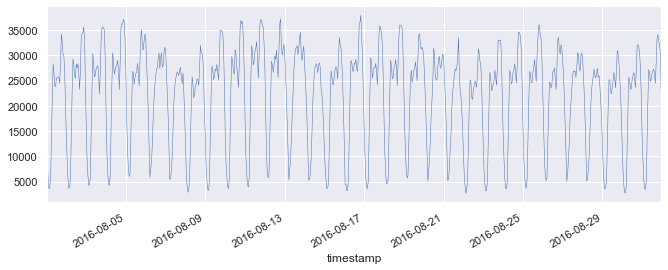

In [33]:
df_tmp = data_final[(data_final.index > '2016-08-01') & (data_final.index<'2016-09-01')]
df_tmp['passenger_count'].plot(linewidth=0.5);

# Prediction Model

In [34]:
df_y = data_final.passenger_count
#df_x = data_final[['hourOfDay']]
df_x = data_final.drop("passenger_count", axis=1)

## Exploratory Analysis

Assume there is corelation between previous number of passagers and current. Let's plot the correlation

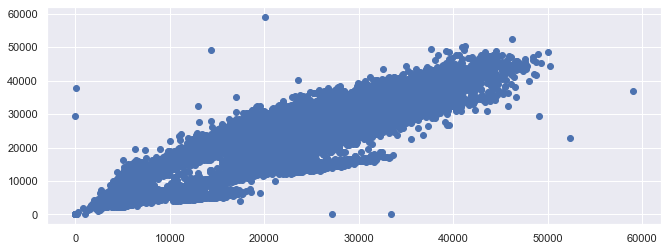

In [35]:
plt.scatter(data_final['passenger_count'],data_final['prev_passenger_count'])

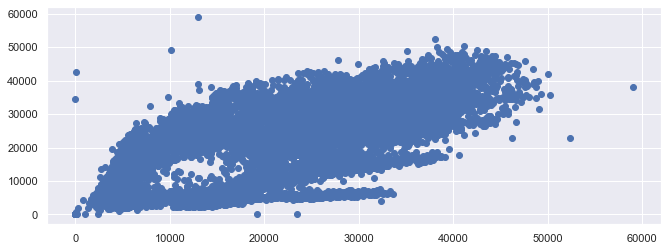

In [36]:
plt.scatter(data_final['passenger_count'],data_final['prev_2hpassenger_count'])

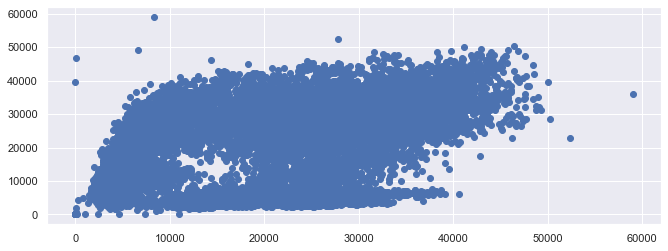

In [37]:
plt.scatter(data_final['passenger_count'],data_final['prev_3hpassenger_count'])

<b>Observations</b>
* There is the correlation between passenger_count and prev_passenger_count

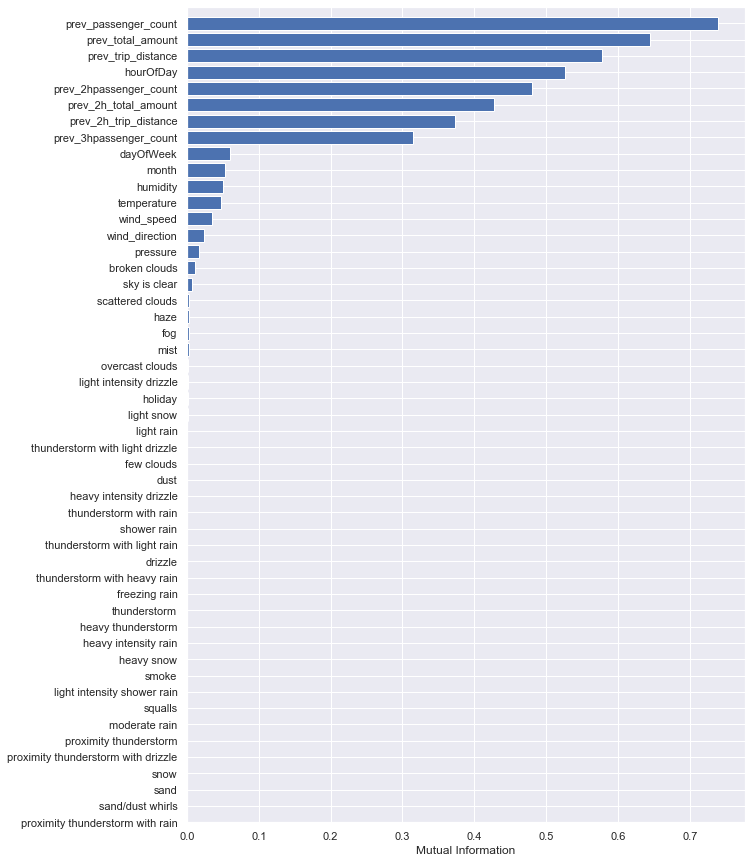

In [38]:
categorical_cols = df_x.select_dtypes(include=['int64', 'uint8'])
continuous_cols = df_x.select_dtypes(exclude=['int64', 'uint8'])

mi_continuous = mutual_info_regression(continuous_cols, df_y, discrete_features=False, n_neighbors = 3, 
                                    random_state=42)


mi_categorical = mutual_info_regression(categorical_cols, df_y, discrete_features=True, n_neighbors = 3, 
                                     random_state=42)
def plot_mutual_info(data, columns):
    inds = np.argsort(data)
    plt.figure(figsize = (10,15))
    plt.barh(np.arange(len(data)), np.log(np.array(data)[inds] + 1))
    plt.yticks(np.arange(len(data)), np.array(columns)[inds])
    plt.ylim(0, len(data))
    plt.xlabel('Mutual Information')
mutual_info = mi_categorical.tolist() + mi_continuous.tolist()
mutual_info_columns = categorical_cols.columns.tolist() + continuous_cols.columns.tolist() 
plot_mutual_info(mutual_info, mutual_info_columns)     

### Train-Test Split
Split data into train and test

In [39]:
X = np.array(df_x.values)
Y = df_y.values
train_size = int(len(X) * 0.75)

X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = Y[0:train_size], Y[train_size:len(X)]

print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(X_train)))
print('Testing Observations: %d' % (len(X_test)))


Observations: 17473
Training Observations: 13104
Testing Observations: 4369


In [40]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Model : Linear Regression

First try simple regression model

In [41]:
regressor = LinearRegression() 
regressor.fit(X_train, y_train) 
y_pred = regressor.predict(X_test)

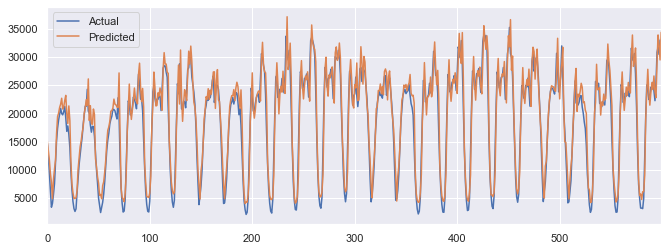

In [42]:
tmp_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
tmp_df = tmp_df.head(600)
tmp_df.plot()

In [43]:
mape_errors_lr = mean_absolute_percentage_error(y_test, y_pred)
mae_errors_lr = mean_absolute_error(y_test, y_pred)

print('Mean Absolute Error:', mae_errors_lr)  
print('MAPE:', mape_errors_lr)  

Mean Absolute Error: 1970.4715436844765
MAPE: 15.136991598993966


## Model: Random Forest Regressor

In [44]:
rf_pipe = make_pipeline(RandomForestRegressor(n_jobs=-1))
rf_params = {'randomforestregressor__n_estimators' : [50, 100, 200], 
             'randomforestregressor__max_features' : ["auto", "sqrt", "log2"],
             'randomforestregressor__max_depth' : [5, 9, 11, 15, 17, 21],
             'randomforestregressor__warm_start' : [True, False]
}
rf_grid = GridSearchCV(rf_pipe, rf_params, cv=5, scoring='r2', verbose=2, n_jobs=-1)

In [ ]:
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.1min


In [ ]:
y_pred = rf_grid.predict(X_test)
tmp_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
tmp_df = tmp_df.head(600)
tmp_df.plot()

In [ ]:
mape_errors_rfr = mean_absolute_percentage_error(y_test, y_pred)
mae_errors_rfr = mean_absolute_error(y_test, y_pred)

print('Mean Absolute Error:', mae_errors_rfr)  
print('MAPE:', mape_errors_rfr)  

## Model: LSTM

In [ ]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

y_train_scaled = scaler.fit_transform(y_train.reshape((y_train.shape[0], -1)))
y_test_scaled = scaler.fit_transform(y_test.reshape((y_test.shape[0], -1)))
print(X_train_scaled.shape, X_test_scaled.shape, y_train_scaled.shape, y_test_scaled.shape)

In [ ]:
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [ ]:
np.random.seed(7)
# design network
model = Sequential()
model.add(LSTM(50, 
               input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
              return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, 
               input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
              return_sequences=False))

model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='mae', optimizer='adam')


# fit network
history = model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=128,
                    validation_data=(X_test_scaled, y_test_scaled), verbose=2, shuffle=False)

In [ ]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [ ]:
test_predict = model.predict(X_test_scaled)
# invert predictions
test_predict = scaler.inverse_transform(test_predict)
y_pred = test_predict[:,0]

In [ ]:
tmp_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
tmp_df = tmp_df.head(600)
tmp_df.plot()

In [ ]:
mape_errors_lstm  = mean_absolute_percentage_error(y_test, y_pred)
mae_errors_lstm = mean_absolute_error(y_test, y_pred)

print('Mean Absolute Error:', mae_errors_lstm)  
print('MAPE:', mape_errors_lstm )  

# Result

In [ ]:
mape_errors = []
mae_errors = []

mape_errors.append(mape_errors_lr)
mae_errors.append(mae_errors_lr)
mape_errors.append(mape_errors_rfr)
mae_errors.append(mae_errors_rfr)
mape_errors.append(mape_errors_lstm)
mae_errors.append(mae_errors_lstm)

In [ ]:
df = pd.DataFrame(dict(graph=['Linear Regression','Random Forest Regression', 'LSTM'],
                           n=mape_errors, m=mae_errors)) 
ind = np.arange(len(df))
fig, ax = plt.subplots()
width=200
ax.barh(ind, df.n, 0.4, label='MAPE')
fig.set_figwidth(7)
plt.title("Mean Absolute Percentage Error for models")
ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend()
plt.show()

In [ ]:
ind = np.arange(len(df))
fig, ax = plt.subplots()
ax.barh(ind, df.m, 0.4, label='MAE')
fig.set_figwidth(7)
plt.title("Mean Absolute Error for models")
ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend()
plt.show()

# Anomaly Detection

Use some anomaly detection methods on the label and search for unusual patterns in taxi demands.

In [ ]:
data_final['passenger_count'].plot(linewidth=0.5);

In [ ]:
seed(1)
anomalies = []

# multiply and add by random numbers to get some real values
data = np.random.randn(50000)  * 20 + 20

# Function to Detection Outlier on one-dimentional datasets.
def find_anomalies(random_data):
    # Set upper and lower limit to 3 standard deviation
    random_data_std = std(random_data)
    random_data_mean = mean(random_data)
    anomaly_cut_off = random_data_std * 3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    print(lower_limit)
    # Generate outliers
    for outlier in random_data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies

find_anomalies(data)

In [ ]:
from sklearn.ensemble import IsolationForest
import numpy as np
np.random.seed(1)
random_data = np.random.randn(50000,2)  * 20 + 20

clf = IsolationForest( behaviour = 'new', max_samples=100, random_state = 1, contamination= 'auto')
preds = clf.fit_predict(random_data)
preds